# Matrix Factorization with SVD
## Comparing SVD vs Traditional Collaborative Filtering


---


## 1. Setup and Data Loading


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, TruncatedSVD
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import time

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [2]:
# Load enhanced data
DATA_PATH = '../data/processed/enhanced_home_kitchen_qa.pkl'

print(f"Loading enhanced data from: {DATA_PATH}")
df = pd.read_pickle(DATA_PATH)

print(f"✓ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nDataset info:")
print(f"  - Users: {df['user_id'].nunique():,}")
print(f"  - Items (ASINs): {df['asin'].nunique():,}")
print(f"  - Ratings: {df['rating'].count():,}")
print(f"  - Rating range: [{df['rating'].min():.1f}, {df['rating'].max():.1f}]")
print(f"  - Average rating: {df['rating'].mean():.3f}")


Loading enhanced data from: ../data/processed/enhanced_home_kitchen_qa.pkl
✓ Data loaded successfully!
Shape: (184439, 40)

Dataset info:
  - Users: 159,477
  - Items (ASINs): 24,501
  - Ratings: 184,439
  - Rating range: [1.0, 5.0]
  - Average rating: 3.580


## 2. Prepare Data for Collaborative Filtering


In [3]:
# Prepare user-item interaction data
# Aggregate user-item interactions (in case of multiple answers per user-item pair)
user_item_df = df.groupby(['user_id', 'asin']).agg({
    'rating': 'mean',
    'sentiment_compound': 'mean',
    'answer': 'count'
}).reset_index()
user_item_df.columns = ['user_id', 'asin', 'rating', 'sentiment', 'interaction_count']

# Filter for quality (minimum interactions)
MIN_USER_INTERACTIONS = 2
MIN_ITEM_INTERACTIONS = 5

user_counts = user_item_df.groupby('user_id').size()
item_counts = user_item_df.groupby('asin').size()

valid_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index
valid_items = item_counts[item_counts >= MIN_ITEM_INTERACTIONS].index

cf_df = user_item_df[
    (user_item_df['user_id'].isin(valid_users)) & 
    (user_item_df['asin'].isin(valid_items))
].copy()

print(f"\n✓ CF dataset prepared:")
print(f"  - Total interactions: {len(cf_df):,}")
print(f"  - Unique users: {cf_df['user_id'].nunique():,}")
print(f"  - Unique items: {cf_df['asin'].nunique():,}")
print(f"  - Rating distribution:")
print(cf_df['rating'].value_counts().sort_index())



✓ CF dataset prepared:
  - Total interactions: 28,219
  - Unique users: 5,686
  - Unique items: 10,204
  - Rating distribution:
rating
1.0694    7
1.1130    3
1.1190    3
1.1362    5
1.1508    3
         ..
4.9856    2
4.9858    2
4.9872    2
4.9886    2
4.9902    2
Name: count, Length: 1432, dtype: int64


In [4]:
# Train-Test Split
print("\nSplitting data into train and test sets...")
train_df, test_df = train_test_split(cf_df, test_size=0.2, random_state=42, stratify=cf_df['rating'].round())

print(f"✓ Data split completed:")
print(f"  - Training set: {len(train_df):,} interactions")
print(f"  - Test set: {len(test_df):,} interactions")
print(f"  - Train users: {train_df['user_id'].nunique():,}")
print(f"  - Train items: {train_df['asin'].nunique():,}")

# Calculate sparsity
n_users = cf_df['user_id'].nunique()
n_items = cf_df['asin'].nunique()
sparsity = 1 - (len(cf_df) / (n_users * n_items))
print(f"\n  - Matrix sparsity: {sparsity:.4%}")



Splitting data into train and test sets...
✓ Data split completed:
  - Training set: 22,575 interactions
  - Test set: 5,644 interactions
  - Train users: 5,536
  - Train items: 8,925

  - Matrix sparsity: 99.9514%


## 3. Traditional Collaborative Filtering Baselines

Implement Item-Item and User-User CF for comparison.


In [5]:
# Create user-item mappings
user_to_idx = {user: idx for idx, user in enumerate(cf_df['user_id'].unique())}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
item_to_idx = {item: idx for idx, item in enumerate(cf_df['asin'].unique())}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

n_users = len(user_to_idx)
n_items = len(item_to_idx)

# Create sparse user-item matrix from training data
print("Creating user-item matrix...")
train_row = train_df['user_id'].map(user_to_idx).values
train_col = train_df['asin'].map(item_to_idx).values
train_ratings = train_df['rating'].values

user_item_matrix = csr_matrix((train_ratings, (train_row, train_col)), shape=(n_users, n_items))

print(f"✓ User-Item Matrix created: {n_users} x {n_items}")
print(f"  - Non-zero entries: {user_item_matrix.nnz:,}")
print(f"  - Sparsity: {1 - user_item_matrix.nnz / (n_users * n_items):.4%}")

# Global mean
global_mean = train_ratings.mean()
print(f"  - Global mean rating: {global_mean:.3f}")


Creating user-item matrix...
✓ User-Item Matrix created: 5686 x 10204
  - Non-zero entries: 22,575
  - Sparsity: 99.9611%
  - Global mean rating: 3.463


In [9]:
# Compute Item-Item and User-User Similarities
print("\nComputing similarity matrices...")
start_time = time.time()

# Item-Item Similarity (cosine)
item_matrix = user_item_matrix.T
item_similarity = cosine_similarity(item_matrix)
np.fill_diagonal(item_similarity, 0)
print(f"Item similarity matrix: {item_similarity.shape}")

# User-User Similarity (cosine)
user_similarity = cosine_similarity(user_item_matrix)
np.fill_diagonal(user_similarity, 0)
print(f"User similarity matrix: {user_similarity.shape}")

# User and item statistics
user_sums = np.array(user_item_matrix.sum(axis=1)).flatten()
user_counts = np.array((user_item_matrix > 0).sum(axis=1)).flatten()
user_counts[user_counts == 0] = 1
user_means = user_sums / user_counts

item_sums = np.array(user_item_matrix.sum(axis=0)).flatten()
item_counts = np.array((user_item_matrix > 0).sum(axis=0)).flatten()
item_counts[item_counts == 0] = 1
item_means = item_sums / item_counts


Computing similarity matrices...
Item similarity matrix: (10204, 10204)
User similarity matrix: (5686, 5686)


In [10]:
# Traditional CF Prediction Functions
def predict_item_cf(user_id, item_id, k=20):
    """Item-Item Collaborative Filtering prediction."""
    if user_id not in user_to_idx or item_id not in item_to_idx:
        return global_mean
    
    user_idx = user_to_idx[user_id]
    item_idx = item_to_idx[item_id]
    
    # Get user's ratings
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    if len(rated_items) == 0:
        return global_mean
    
    # Get similar items
    similarities = item_similarity[item_idx][rated_items]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    top_k_items = rated_items[top_k_indices]
    top_k_sims = similarities[top_k_indices]
    
    # Calculate weighted average
    numerator = sum(top_k_sims[i] * user_ratings[top_k_items[i]] for i in range(len(top_k_items)) if top_k_sims[i] > 0)
    denominator = sum(abs(s) for s in top_k_sims if s > 0)
    
    if denominator == 0:
        return global_mean
    
    return numerator / denominator

def predict_user_cf(user_id, item_id, k=20):
    """User-User Collaborative Filtering prediction."""
    if user_id not in user_to_idx or item_id not in item_to_idx:
        return global_mean
    
    user_idx = user_to_idx[user_id]
    item_idx = item_to_idx[item_id]
    user_mean = user_means[user_idx] if user_means[user_idx] > 0 else global_mean
    
    # Get item's ratings
    item_ratings = user_item_matrix[:, item_idx].toarray().flatten()
    rated_users = np.where(item_ratings > 0)[0]
    
    if len(rated_users) == 0:
        return user_mean
    
    # Get similar users
    similarities = user_similarity[user_idx][rated_users]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    top_k_users = rated_users[top_k_indices]
    top_k_sims = similarities[top_k_indices]
    
    # Calculate weighted average with mean-centering
    numerator = sum(top_k_sims[i] * (item_ratings[top_k_users[i]] - user_means[top_k_users[i]]) 
                   for i in range(len(top_k_users)) if top_k_sims[i] > 0)
    denominator = sum(abs(s) for s in top_k_sims if s > 0)
    
    if denominator == 0:
        return user_mean
    
    pred = user_mean + (numerator / denominator)
    return np.clip(pred, 1, 5)

## 4. Matrix Factorization with SVD (Custom Implementation)

Implement SVD using Stochastic Gradient Descent - no external MF libraries needed!


In [11]:
# Custom SVD Implementation with Stochastic Gradient Descent
class MatrixFactorizationSVD:
    """
    Matrix Factorization using SGD for collaborative filtering.
    Learns latent factors for users and items to predict ratings.
    """
    def __init__(self, n_factors=50, n_epochs=20, lr=0.005, reg=0.02, random_state=42):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.random_state = random_state
        
    def fit(self, user_item_matrix, verbose=True):
        """Train the SVD model"""
        np.random.seed(self.random_state)
        
        self.n_users, self.n_items = user_item_matrix.shape
        self.global_mean = user_item_matrix.data.mean()
        
        # Initialize latent factors
        self.user_factors = np.random.normal(0, 0.1, (self.n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (self.n_items, self.n_factors))
        
        # Initialize biases
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_items)
        
        # Get non-zero entries
        rows, cols = user_item_matrix.nonzero()
        ratings = user_item_matrix.data
        
        # Training loop
        for epoch in range(self.n_epochs):
            # Shuffle data
            indices = np.random.permutation(len(rows))
            epoch_loss = 0
            
            for idx in indices:
                u, i, r = rows[idx], cols[idx], ratings[idx]
                
                # Predict
                pred = self.global_mean + self.user_bias[u] + self.item_bias[i] + \
                       np.dot(self.user_factors[u], self.item_factors[i])
                
                # Calculate error
                error = r - pred
                epoch_loss += error ** 2
                
                # Update biases
                self.user_bias[u] += self.lr * (error - self.reg * self.user_bias[u])
                self.item_bias[i] += self.lr * (error - self.reg * self.item_bias[i])
                
                # Update latent factors
                user_f = self.user_factors[u].copy()
                self.user_factors[u] += self.lr * (error * self.item_factors[i] - self.reg * self.user_factors[u])
                self.item_factors[i] += self.lr * (error * user_f - self.reg * self.item_factors[i])
            
            # Calculate RMSE for this epoch
            rmse = np.sqrt(epoch_loss / len(rows))
            if verbose and (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{self.n_epochs} - RMSE: {rmse:.4f}")
        
        return self
    
    def predict(self, user_id, item_id):
        """Predict rating for a user-item pair"""
        if user_id >= self.n_users or item_id >= self.n_items:
            return self.global_mean
        
        pred = self.global_mean + self.user_bias[user_id] + self.item_bias[item_id] + \
               np.dot(self.user_factors[user_id], self.item_factors[item_id])
        
        return np.clip(pred, 1, 5)
    
    def predict_all(self, user_ids, item_ids):
        """Predict ratings for multiple user-item pairs"""
        predictions = []
        for u, i in zip(user_ids, item_ids):
            predictions.append(self.predict(u, i))
        return np.array(predictions)

In [ ]:
# Train SVD model
print("\n" + "="*80)
print("TRAINING SVD MODEL (Custom SGD Implementation)")
print("="*80)

start_time = time.time()

# Initialize and train SVD model
svd_model = MatrixFactorizationSVD(
    n_factors=50,        # Number of latent factors
    n_epochs=20,         # Number of iterations
    lr=0.005,            # Learning rate
    reg=0.02,            # Regularization term
    random_state=42
)

# Train the model
svd_model.fit(user_item_matrix, verbose=True)

training_time = time.time() - start_time
print(f"\nSVD model trained in {training_time:.2f}s")
print(f"  - Latent factors: {svd_model.n_factors}")
print(f"  - Epochs: {svd_model.n_epochs}")
print(f"  - Learning rate: {svd_model.lr}")
print(f"  - Regularization: {svd_model.reg}")



TRAINING SVD MODEL (Custom SGD Implementation)
Epoch 5/20 - RMSE: 0.5881
Epoch 10/20 - RMSE: 0.5049
Epoch 15/20 - RMSE: 0.4439
Epoch 20/20 - RMSE: 0.3956

✓ SVD model trained in 3.85s
  - Latent factors: 50
  - Epochs: 20
  - Learning rate: 0.005
  - Regularization: 0.02


## 5. Advanced Matrix Factorization Variants

Implement NMF (sklearn) and TruncatedSVD for comparison.


In [13]:
# Train TruncatedSVD model (fast sklearn implementation)
print("\n" + "="*80)
print("TRAINING TRUNCATED SVD MODEL (sklearn)")
print("="*80)

start_time = time.time()

truncsvd_model = TruncatedSVD(
    n_components=30,
    n_iter=20,
    random_state=42
)

# Fit on the user-item matrix
truncsvd_model.fit(user_item_matrix)

# Get latent representations
user_latent = truncsvd_model.transform(user_item_matrix)
item_latent = truncsvd_model.components_.T

training_time = time.time() - start_time
print(f"\n✓ TruncatedSVD model trained in {training_time:.2f}s")
print(f"  - Latent components: {truncsvd_model.n_components}")
print(f"  - Explained variance ratio: {truncsvd_model.explained_variance_ratio_.sum():.4f}")



TRAINING TRUNCATED SVD MODEL (sklearn)

✓ TruncatedSVD model trained in 0.59s
  - Latent components: 30
  - Explained variance ratio: 0.3347


In [14]:
# Train NMF model (Non-negative Matrix Factorization from sklearn)
print("\n" + "="*80)
print("TRAINING NMF MODEL (sklearn)")
print("="*80)

start_time = time.time()

nmf_model = NMF(
    n_components=30,
    init='random',
    random_state=42,
    max_iter=200,
    alpha_W=0.02,  # Regularization for W (user factors)
    alpha_H=0.02,  # Regularization for H (item factors)
    l1_ratio=0.0   # L2 regularization only
)

# Fit on the user-item matrix  
nmf_model.fit(user_item_matrix)

# Get latent representations
nmf_user_latent = nmf_model.transform(user_item_matrix)
nmf_item_latent = nmf_model.components_.T

training_time = time.time() - start_time
print(f"\n✓ NMF model trained in {training_time:.2f}s")
print(f"  - Latent components: {nmf_model.n_components}")
print(f"  - Reconstruction error: {nmf_model.reconstruction_err_:.4f}")
print(f"  - Non-negative constraints for interpretability")



TRAINING NMF MODEL (sklearn)

✓ NMF model trained in 0.14s
  - Latent components: 30
  - Reconstruction error: 522.6971
  - Non-negative constraints for interpretability


## 6. Generate Predictions for All Models


In [15]:
# Generate predictions for all models
print("\n" + "="*80)
print("GENERATING PREDICTIONS")
print("="*80)

y_test = test_df['rating'].values

# Baseline: Global Mean
baseline_pred = np.full(len(y_test), global_mean)
print("✓ Baseline predictions generated")

# Traditional CF predictions
print("\nGenerating traditional CF predictions...")
item_cf_pred = []
user_cf_pred = []

for _, row in test_df.iterrows():
    item_cf_pred.append(predict_item_cf(row['user_id'], row['asin'], k=20))
    user_cf_pred.append(predict_user_cf(row['user_id'], row['asin'], k=20))

item_cf_pred = np.array(item_cf_pred)
user_cf_pred = np.array(user_cf_pred)
print("✓ Item-Item CF predictions generated")
print("✓ User-User CF predictions generated")

# Matrix Factorization predictions
print("\nGenerating Matrix Factorization predictions...")

# Custom SVD predictions
test_user_indices = test_df['user_id'].map(user_to_idx).values
test_item_indices = test_df['asin'].map(item_to_idx).values
svd_pred = svd_model.predict_all(test_user_indices, test_item_indices)
print("✓ SVD (Custom SGD) predictions generated")

# TruncatedSVD predictions
truncsvd_pred = []
for u_idx, i_idx in zip(test_user_indices, test_item_indices):
    if u_idx < len(user_latent) and i_idx < len(item_latent):
        pred = global_mean + np.dot(user_latent[u_idx], item_latent[i_idx])
        truncsvd_pred.append(np.clip(pred, 1, 5))
    else:
        truncsvd_pred.append(global_mean)
truncsvd_pred = np.array(truncsvd_pred)
print("✓ TruncatedSVD predictions generated")

# NMF predictions
nmf_pred = []
for u_idx, i_idx in zip(test_user_indices, test_item_indices):
    if u_idx < len(nmf_user_latent) and i_idx < len(nmf_item_latent):
        pred = global_mean + np.dot(nmf_user_latent[u_idx], nmf_item_latent[i_idx])
        nmf_pred.append(np.clip(pred, 1, 5))
    else:
        nmf_pred.append(global_mean)
nmf_pred = np.array(nmf_pred)
print("✓ NMF predictions generated")

print("\n✓ All predictions completed!")



GENERATING PREDICTIONS
✓ Baseline predictions generated

Generating traditional CF predictions...
✓ Item-Item CF predictions generated
✓ User-User CF predictions generated

Generating Matrix Factorization predictions...
✓ SVD (Custom SGD) predictions generated
✓ TruncatedSVD predictions generated
✓ NMF predictions generated

✓ All predictions completed!


## 7. Comprehensive Model Evaluation


In [17]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics for a model."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Evaluate all models
print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

results = []

# Baselines
results.append(evaluate_model(y_test, baseline_pred, 'Baseline (Global Mean)'))

# Traditional CF
results.append(evaluate_model(y_test, item_cf_pred, 'Traditional CF: Item-Item'))
results.append(evaluate_model(y_test, user_cf_pred, 'Traditional CF: User-User'))

# Matrix Factorization
results.append(evaluate_model(y_test, svd_pred, 'Matrix Factorization: SVD (SGD)'))
results.append(evaluate_model(y_test, truncsvd_pred, 'Matrix Factorization: TruncatedSVD'))
results.append(evaluate_model(y_test, nmf_pred, 'Matrix Factorization: NMF'))

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Highlight best model
best_model = results_df.iloc[0]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.4f} | MAE: {best_model['MAE']:.4f} | R²: {best_model['R²']:.4f}")



MODEL EVALUATION RESULTS

COMPREHENSIVE PERFORMANCE COMPARISON
                             Model     RMSE      MAE        R²
         Traditional CF: User-User 0.172414 0.032991  0.948855
         Traditional CF: Item-Item 0.376636 0.197254  0.755937
   Matrix Factorization: SVD (SGD) 0.516765 0.360587  0.540545
            Baseline (Global Mean) 0.762387 0.653542 -0.000019
         Matrix Factorization: NMF 0.762852 0.653400 -0.001239
Matrix Factorization: TruncatedSVD 0.867937 0.714075 -0.296085

BEST MODEL: Traditional CF: User-User
   RMSE: 0.1724 | MAE: 0.0330 | R²: 0.9489


In [19]:
# Save results
import os

OUTPUT_DIR = '../data/results/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

results_path = os.path.join(OUTPUT_DIR, 'svd_cf_comparison.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to: {results_path}")



Results saved to: ../data/results/svd_cf_comparison.csv


## 8. Visualization: Performance Comparison



✓ Comparison plot saved to: ../visualizations/svd/svd_cf_comparison.png


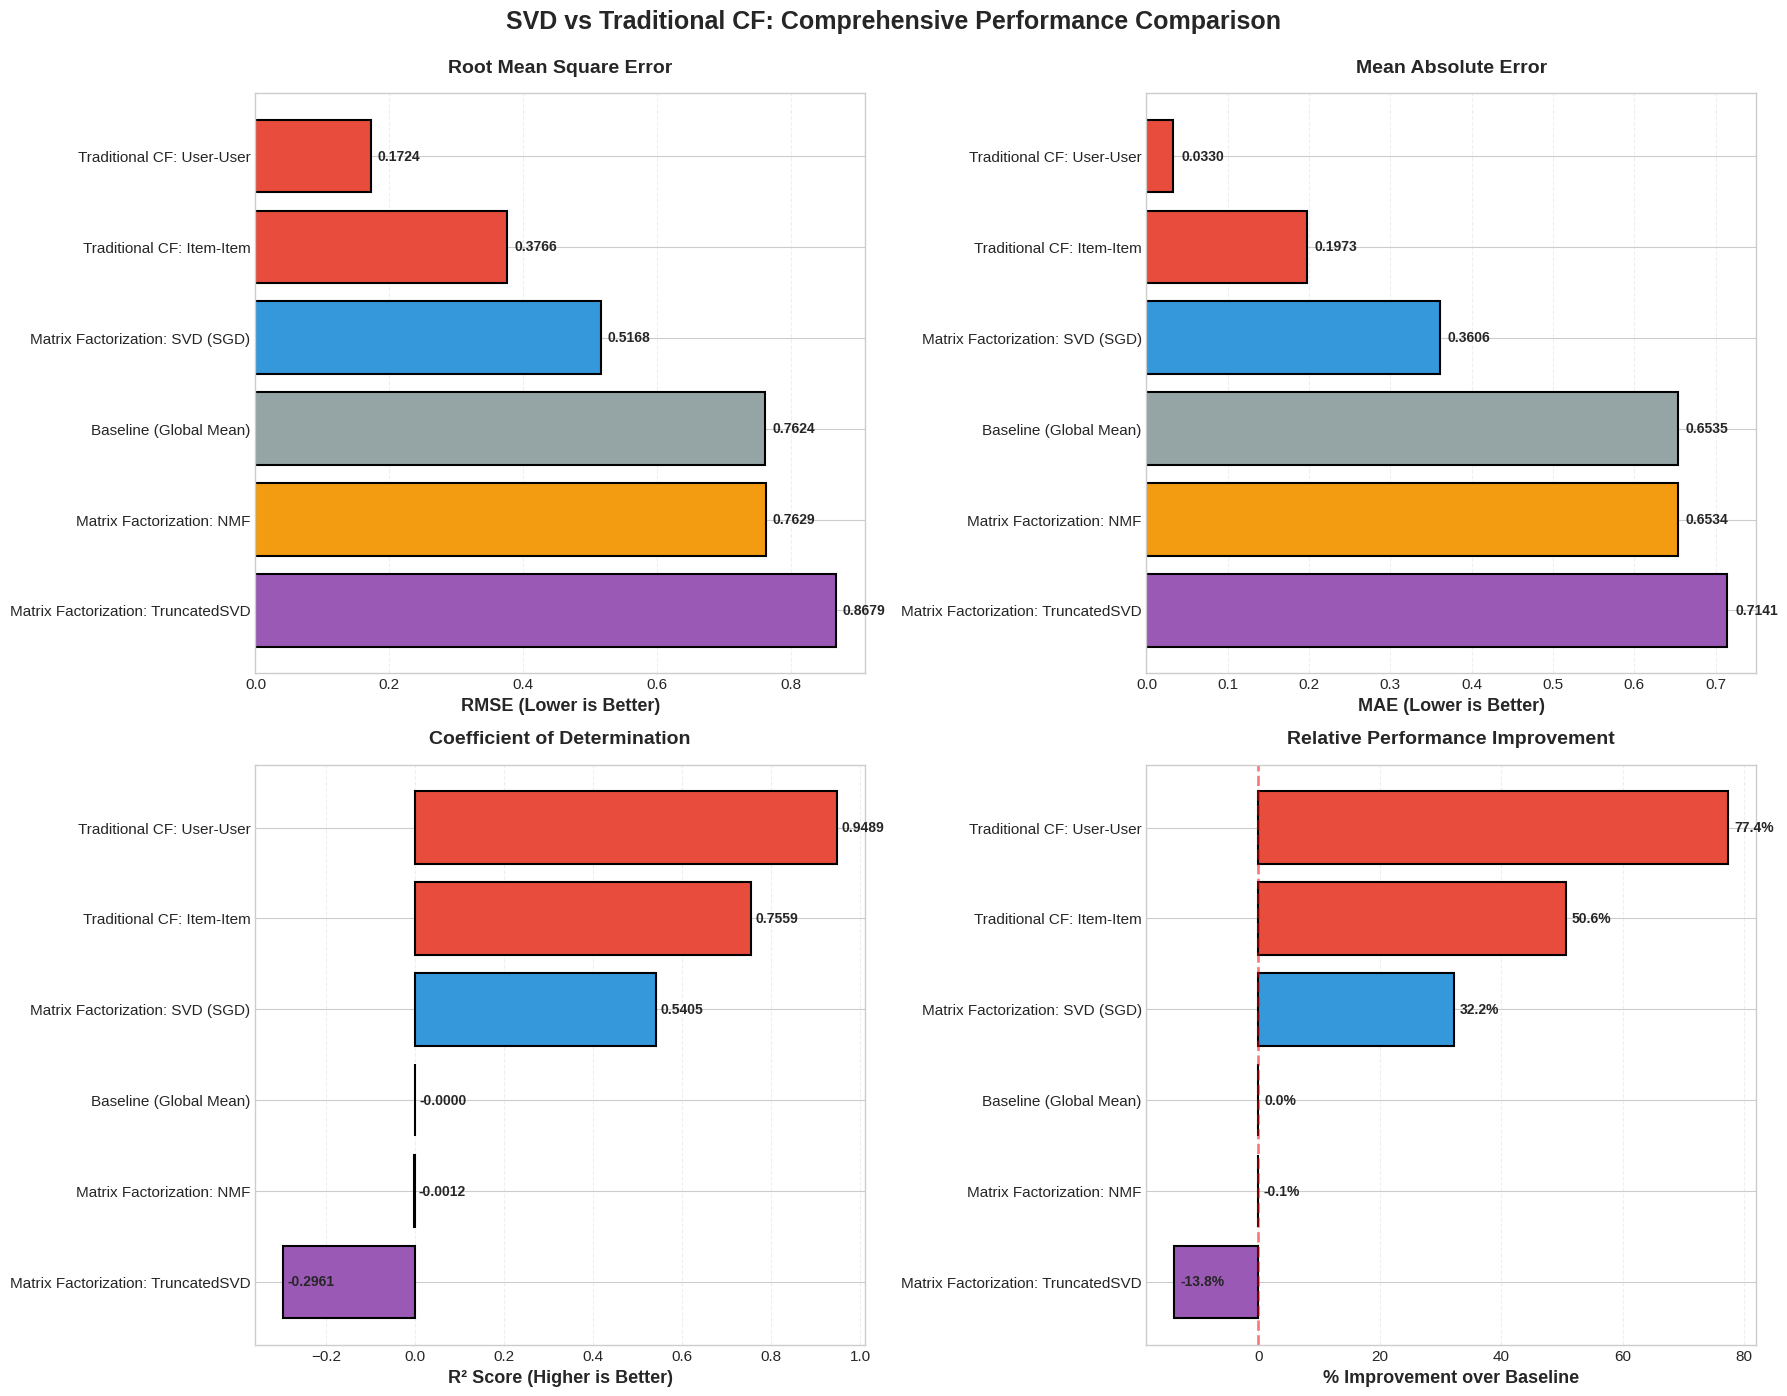

In [20]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('SVD vs Traditional CF: Comprehensive Performance Comparison', 
             fontsize=18, fontweight='bold', y=0.995)

# Define colors for model types
def get_model_color(model_name):
    if 'Baseline' in model_name:
        return '#95a5a6'  # Gray
    elif 'Traditional CF' in model_name:
        return '#e74c3c'  # Red
    elif 'TruncatedSVD' in model_name:
        return '#9b59b6'  # Purple
    elif 'SVD' in model_name:
        return '#3498db'  # Blue
    elif 'NMF' in model_name:
        return '#f39c12'  # Orange
    return '#34495e'

model_colors = [get_model_color(m) for m in results_df['Model']]

# 1. RMSE Comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(range(len(results_df)), results_df['RMSE'], color=model_colors, 
                  edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(results_df)))
ax1.set_yticklabels(results_df['Model'], fontsize=11)
ax1.set_xlabel('RMSE (Lower is Better)', fontsize=13, fontweight='bold')
ax1.set_title('Root Mean Square Error', fontsize=14, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, v in enumerate(results_df['RMSE']):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

# 2. MAE Comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(range(len(results_df)), results_df['MAE'], color=model_colors,
                  edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(results_df)))
ax2.set_yticklabels(results_df['Model'], fontsize=11)
ax2.set_xlabel('MAE (Lower is Better)', fontsize=13, fontweight='bold')
ax2.set_title('Mean Absolute Error', fontsize=14, fontweight='bold', pad=15)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, v in enumerate(results_df['MAE']):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

# 3. R² Comparison
ax3 = axes[1, 0]
bars3 = ax3.barh(range(len(results_df)), results_df['R²'], color=model_colors,
                  edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(results_df)))
ax3.set_yticklabels(results_df['Model'], fontsize=11)
ax3.set_xlabel('R² Score (Higher is Better)', fontsize=13, fontweight='bold')
ax3.set_title('Coefficient of Determination', fontsize=14, fontweight='bold', pad=15)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, v in enumerate(results_df['R²']):
    ax3.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

# 4. Improvement Analysis
ax4 = axes[1, 1]
baseline_rmse = results_df[results_df['Model'] == 'Baseline (Global Mean)']['RMSE'].values[0]
improvements = [(baseline_rmse - rmse) / baseline_rmse * 100 for rmse in results_df['RMSE']]

bars4 = ax4.barh(range(len(results_df)), improvements, color=model_colors,
                  edgecolor='black', linewidth=1.5)
ax4.set_yticks(range(len(results_df)))
ax4.set_yticklabels(results_df['Model'], fontsize=11)
ax4.set_xlabel('% Improvement over Baseline', fontsize=13, fontweight='bold')
ax4.set_title('Relative Performance Improvement', fontsize=14, fontweight='bold', pad=15)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3, linestyle='--')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.5)

# Add value labels
for i, v in enumerate(improvements):
    ax4.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save plot
VIZ_DIR = '../visualizations/svd/'
os.makedirs(VIZ_DIR, exist_ok=True)
comparison_plot_path = os.path.join(VIZ_DIR, 'svd_cf_comparison.png')
plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved to: {comparison_plot_path}")

plt.show()


## 9. Prediction Scatter Plots: Actual vs Predicted



✓ Scatter plots saved to: ../visualizations/svd/prediction_scatter_plots.png


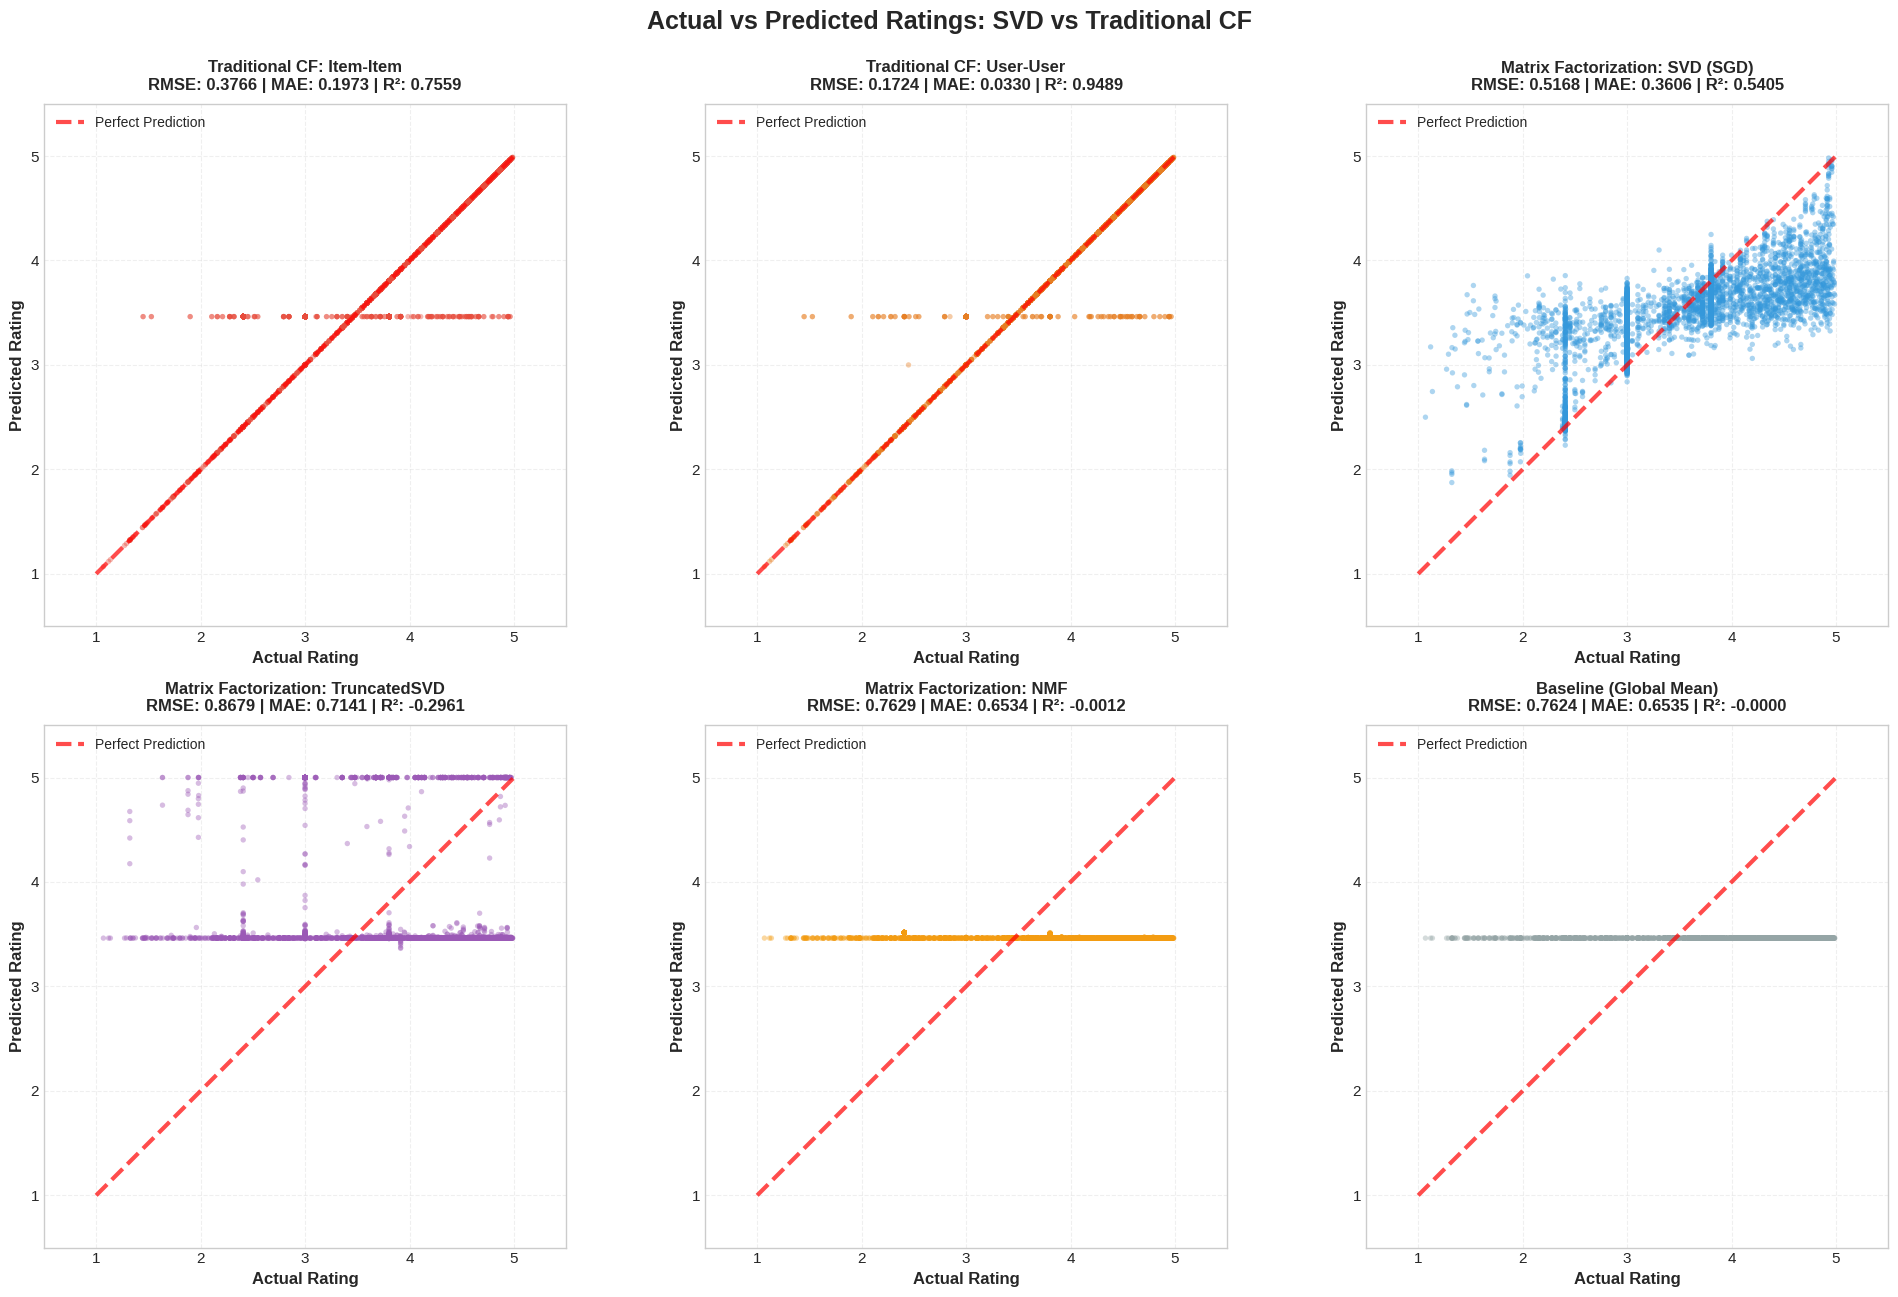

In [21]:
# Scatter plots: Actual vs Predicted for all models
fig, axes = plt.subplots(2, 3, figsize=(20, 13))
fig.suptitle('Actual vs Predicted Ratings: SVD vs Traditional CF', 
             fontsize=18, fontweight='bold', y=0.995)

models_to_plot = [
    ('Traditional CF: Item-Item', item_cf_pred, '#e74c3c'),
    ('Traditional CF: User-User', user_cf_pred, '#e67e22'),
    ('Matrix Factorization: SVD (SGD)', svd_pred, '#3498db'),
    ('Matrix Factorization: TruncatedSVD', truncsvd_pred, '#9b59b6'),
    ('Matrix Factorization: NMF', nmf_pred, '#f39c12'),
    ('Baseline (Global Mean)', baseline_pred, '#95a5a6')
]

for idx, (model_name, predictions, color) in enumerate(models_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Scatter plot with transparency
    ax.scatter(y_test, predictions, alpha=0.4, s=15, color=color, edgecolors='none')
    
    # Perfect prediction line
    ax.plot([1, 5], [1, 5], 'r--', lw=3, label='Perfect Prediction', alpha=0.7)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    ax.set_xlabel('Actual Rating', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Rating', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}\nRMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}', 
                 fontsize=12, fontweight='bold', pad=10)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0.5, 5.5)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_aspect('equal')

plt.tight_layout()

# Save plot
scatter_plot_path = os.path.join(VIZ_DIR, 'prediction_scatter_plots.png')
plt.savefig(scatter_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Scatter plots saved to: {scatter_plot_path}")

plt.show()


## 10. Extract Latent Factors for Hybrid Models


In [22]:
# Extract latent factors from SVD model
print("\n" + "="*80)
print("EXTRACTING LATENT FACTORS FROM SVD")
print("="*80)

# Access user and item latent factors (already stored in model)
user_factors_dict = {}
item_factors_dict = {}

# Create dictionaries mapping external IDs to latent factors
for idx, user_id in enumerate(cf_df['user_id'].unique()):
    if idx < len(svd_model.user_factors):
        user_factors_dict[user_id] = svd_model.user_factors[idx]

for idx, item_id in enumerate(cf_df['asin'].unique()):
    if idx < len(svd_model.item_factors):
        item_factors_dict[item_id] = svd_model.item_factors[idx]

print(f"Extracted latent factors:")
print(f"  - User factors: {len(user_factors_dict):,} users x {svd_model.n_factors} factors")
print(f"  - Item factors: {len(item_factors_dict):,} items x {svd_model.n_factors} factors")

# Get user and item biases
user_bias_dict = {}
item_bias_dict = {}

for idx, user_id in enumerate(cf_df['user_id'].unique()):
    if idx < len(svd_model.user_bias):
        user_bias_dict[user_id] = svd_model.user_bias[idx]

for idx, item_id in enumerate(cf_df['asin'].unique()):
    if idx < len(svd_model.item_bias):
        item_bias_dict[item_id] = svd_model.item_bias[idx]

print(f"✓ Extracted biases:")
print(f"  - User biases: {len(user_bias_dict):,}")
print(f"  - Item biases: {len(item_bias_dict):,}")



EXTRACTING LATENT FACTORS FROM SVD
Extracted latent factors:
  - User factors: 5,686 users x 50 factors
  - Item factors: 10,204 items x 50 factors
✓ Extracted biases:
  - User biases: 5,686
  - Item biases: 10,204


In [23]:
# Create MF-based features for hybrid model
def extract_mf_features(data_df):
    """Extract SVD-based features for each user-item interaction."""
    features = []
    
    for _, row in data_df.iterrows():
        user_id = row['user_id']
        item_id = row['asin']
        
        # Get user and item indices
        u_idx = user_to_idx.get(user_id)
        i_idx = item_to_idx.get(item_id)
        
        # SVD prediction
        if u_idx is not None and i_idx is not None:
            svd_prediction = svd_model.predict(u_idx, i_idx)
        else:
            svd_prediction = svd_model.global_mean
        
        # Get latent factors and compute similarity
        if user_id in user_factors_dict and item_id in item_factors_dict:
            u_factors = user_factors_dict[user_id]
            i_factors = item_factors_dict[item_id]
            latent_similarity = np.dot(u_factors, i_factors)
            
            # Top-5 latent factors from user and item
            top_user_factors = u_factors[:5]
            top_item_factors = i_factors[:5]
        else:
            latent_similarity = 0
            top_user_factors = np.zeros(5)
            top_item_factors = np.zeros(5)
        
        # Get biases
        user_bias = user_bias_dict.get(user_id, 0)
        item_bias = item_bias_dict.get(item_id, 0)
        
        features.append({
            'svd_prediction': svd_prediction,
            'latent_similarity': latent_similarity,
            'user_bias': user_bias,
            'item_bias': item_bias,
            'user_factor_1': top_user_factors[0],
            'user_factor_2': top_user_factors[1],
            'user_factor_3': top_user_factors[2],
            'user_factor_4': top_user_factors[3],
            'user_factor_5': top_user_factors[4],
            'item_factor_1': top_item_factors[0],
            'item_factor_2': top_item_factors[1],
            'item_factor_3': top_item_factors[2],
            'item_factor_4': top_item_factors[3],
            'item_factor_5': top_item_factors[4]
        })
    
    return pd.DataFrame(features)

print("\nExtracting MF features for train and test sets...")
train_mf_features = extract_mf_features(train_df)
test_mf_features = extract_mf_features(test_df)

print(f"✓ MF features extracted:")
print(f"  - Training set: {train_mf_features.shape}")
print(f"  - Test set: {test_mf_features.shape}")
print(f"\nFeature columns:")
print(train_mf_features.columns.tolist())



Extracting MF features for train and test sets...
✓ MF features extracted:
  - Training set: (22575, 14)
  - Test set: (5644, 14)

Feature columns:
['svd_prediction', 'latent_similarity', 'user_bias', 'item_bias', 'user_factor_1', 'user_factor_2', 'user_factor_3', 'user_factor_4', 'user_factor_5', 'item_factor_1', 'item_factor_2', 'item_factor_3', 'item_factor_4', 'item_factor_5']


## 11. Save MF Features for Hybrid Model Integration


In [24]:
# Save MF features and models for later use
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save MF features
train_mf_features_path = os.path.join(OUTPUT_DIR, 'svd_train_features.pkl')
test_mf_features_path = os.path.join(OUTPUT_DIR, 'svd_test_features.pkl')

train_mf_features.to_pickle(train_mf_features_path)
test_mf_features.to_pickle(test_mf_features_path)
print(f"✓ MF features saved:")
print(f"  - Training: {train_mf_features_path}")
print(f"  - Test: {test_mf_features_path}")

# Save latent factor dictionaries
import pickle

factors_path = os.path.join(OUTPUT_DIR, 'svd_latent_factors.pkl')
with open(factors_path, 'wb') as f:
    pickle.dump({
        'user_factors': user_factors_dict,
        'item_factors': item_factors_dict,
        'user_bias': user_bias_dict,
        'item_bias': item_bias_dict,
        'n_factors': svd_model.n_factors
    }, f)
print(f"✓ Latent factors saved: {factors_path}")




SAVING RESULTS
✓ MF features saved:
  - Training: ../data/results/svd_train_features.pkl
  - Test: ../data/results/svd_test_features.pkl
✓ Latent factors saved: ../data/results/svd_latent_factors.pkl


## 12. Key Findings and Insights


In [25]:
# Generate comprehensive insights
print("\n" + "="*80)
print("KEY FINDINGS AND INSIGHTS")
print("="*80)

best_model = results_df.iloc[0]
baseline_rmse = results_df[results_df['Model'] == 'Baseline (Global Mean)']['RMSE'].values[0]

print(f"\n1. BEST PERFORMING MODEL:")
print(f"   Model: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.4f}")
print(f"   MAE: {best_model['MAE']:.4f}")
print(f"   R²: {best_model['R²']:.4f}")

improvement = ((baseline_rmse - best_model['RMSE']) / baseline_rmse) * 100
print(f"\n2. IMPROVEMENT OVER BASELINE:")
print(f"   {improvement:.2f}% reduction in RMSE")

# Compare MF vs Traditional CF
trad_cf_rmse = results_df[results_df['Model'].str.contains('Traditional CF')]['RMSE'].min()
mf_rmse = results_df[results_df['Model'].str.contains('Matrix Factorization')]['RMSE'].min()

if mf_rmse < trad_cf_rmse:
    mf_improvement = ((trad_cf_rmse - mf_rmse) / trad_cf_rmse) * 100
    print(f"\n3. MATRIX FACTORIZATION vs TRADITIONAL CF:")
    print(f"   Matrix Factorization shows {mf_improvement:.2f}% improvement")
    print(f"   Best Traditional CF RMSE: {trad_cf_rmse:.4f}")
    print(f"   Best MF RMSE: {mf_rmse:.4f}")
else:
    print(f"\n3. MATRIX FACTORIZATION vs TRADITIONAL CF:")
    print(f"   Traditional CF performs better in this dataset")
    print(f"   Best Traditional CF RMSE: {trad_cf_rmse:.4f}")
    print(f"   Best MF RMSE: {mf_rmse:.4f}")

# Compare MF variants
print(f"\n4. MATRIX FACTORIZATION VARIANTS COMPARISON:")
for _, row in results_df[results_df['Model'].str.contains('Matrix Factorization')].iterrows():
    print(f"   {row['Model']:30s} RMSE: {row['RMSE']:.4f}  MAE: {row['MAE']:.4f}")




KEY FINDINGS AND INSIGHTS

1. BEST PERFORMING MODEL:
   Model: Traditional CF: User-User
   RMSE: 0.1724
   MAE: 0.0330
   R²: 0.9489

2. IMPROVEMENT OVER BASELINE:
   77.38% reduction in RMSE

3. MATRIX FACTORIZATION vs TRADITIONAL CF:
   Traditional CF performs better in this dataset
   Best Traditional CF RMSE: 0.1724
   Best MF RMSE: 0.5168

4. MATRIX FACTORIZATION VARIANTS COMPARISON:
   Matrix Factorization: SVD (SGD) RMSE: 0.5168  MAE: 0.3606
   Matrix Factorization: NMF      RMSE: 0.7629  MAE: 0.6534
   Matrix Factorization: TruncatedSVD RMSE: 0.8679  MAE: 0.7141
